<center><h1>Notebook for Generating Privileged Information for Object Detection Datasets</h1>
<h2>Matthias Bartolo</h2>

</center>

### Downloading the dataset

In [ ]:
download_datasets = False # True
if download_datasets:
    import os
    import json
    from roboflow import Roboflow

    HOME = os.getcwd()
    # Go back one directory to the root of the project
    HOME = os.path.dirname(HOME)
    print("Downloading datasets to: ", os.path.join(HOME, 'datasets'))

    if not os.path.isdir(os.path.join(HOME, 'datasets')):
        os.mkdir(os.path.join(HOME, 'datasets'))
    os.chdir(os.path.join(HOME, 'datasets'))

    ########################################################## ROBOFLOW ##########################################################
    # SODA Dataset
    rf = Roboflow(api_key="nyynHs3oneLLx01D04rC")
    project = rf.workspace("soda-dataset").project("01m-all")
    version = project.version(1)
    dataset = version.download("coco")

    ########################################################## ROBOFLOW ##########################################################

    # Ensure correct folder structure
    directories = ['train', 'valid', 'test']
    # Change the directories to get the full path
    directories = [os.path.join(dataset.location, directory) for directory in directories]

    for directory in directories:
        os.makedirs(f'{directory}/images', exist_ok=True)  # Create 'images' subfolder

    # Move images to corresponding 'images' subfolders while keeping annotations in the main split folder
    for directory in directories:
        image_dir = os.path.join(dataset.location, directory)  # Original dataset directory
        dest_image_dir = f'{directory}/images'  # Destination images folder

        annotation_file = os.path.join(image_dir, "_annotations.coco.json")
        new_annotation_path = os.path.join(directory, "_annotations.coco.json")

        for file_name in os.listdir(image_dir):  # Iterate over files in the dataset split
            src_path = os.path.join(image_dir, file_name)

            if file_name.endswith('.jpg') or file_name.endswith('.png'):  # Move images
                dest_path = os.path.join(dest_image_dir, file_name)
            elif file_name == "_annotations.coco.json":  # Keep annotations in the main split folder
                dest_path = new_annotation_path
            else:
                continue  # Ignore other file types

            if os.path.isfile(src_path):  # Ensure it's a file before moving
                os.rename(src_path, dest_path)

        # Update _annotations.coco.json to reflect the new image paths
        if os.path.isfile(new_annotation_path):
            with open(new_annotation_path, 'r') as f:
                data = json.load(f)

            for image in data["images"]:
                image["file_name"] = f"{image['file_name']}"  # Update path in annotation

            with open(new_annotation_path, 'w') as f:
                json.dump(data, f, indent=4)  # Save the updated JSON

loading Roboflow workspace...
loading Roboflow project...


### Defining Paths

In [7]:
# Shared imports
import os
import time

# Paths
yolo_dataset_path = "../datasets/01m-All-1/"  # Base path for your COCO dataset
output_base_path = "../datasets/01m-All-1/"   # Base path for saving saliency map images
images_path='images/' # Path to the images in each dataset subfolder

# Saliency Map Generation (Itti Model)

In [ ]:
import os
import cv2
import numpy as np
import SaRa.saraRC1 as sara # Do not change the home directory for this one

GENERATORS = ['itti', 'deepgaze']  # Available saliency generators

start_time = time.time()

def generate_saliency_maps(yolo_dataset_path, output_base_path, generator='itti', images_path='images'):
    """
    Generate and save saliency map images using the SaRa library for a YOLO dataset.

    Args:
        yolo_dataset_path (str): Path to the dataset with train, test, valid folders.
        output_base_path (str): Path to save the saliency map images.
        generator (str): Saliency map generator ('itti' or 'deepgaze').
    """
    if generator not in GENERATORS:
        raise ValueError(f"Invalid generator '{generator}'. Must be one of {GENERATORS}.")

    for subset in ["train", "test", "valid"]:
        input_folder = os.path.join(yolo_dataset_path, subset, images_path)
        output_folder = os.path.join(output_base_path, subset, f"Saliency_{generator}")

        # Check if input folder exists
        if not os.path.exists(input_folder):
            print(f"Skipping {subset} as directory {input_folder} does not exist.")
            continue

        # Create the output folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)

        for image_file in os.listdir(input_folder):
            # Process only image files
            if image_file.endswith(('.jpg', '.png', '.jpeg')):
                image_path = os.path.join(input_folder, image_file)
                output_image_path = os.path.join(output_folder, image_file)

                # Read the image
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                if image is None:
                    print(f"Could not read image {image_path}")
                    continue

                # Apply saliency map generation
                image_np = np.array(image)
                sara_image = image_np.copy()
                sara.reset()
                
                
                saliency_map = sara.return_saliency(sara_image, generator=generator)                

                # Save the processed image
                cv2.imwrite(output_image_path, saliency_map)
                print(f"Saved saliency map image to {output_image_path}")

# Choose saliency generator and generate saliency maps
generator = 'itti'  # Change to 'deepgaze' as needed
generate_saliency_maps(yolo_dataset_path, output_base_path, generator=generator, images_path=images_path)

end_time = time.time()
duration = end_time - start_time
# Save the duration to a file
os.makedirs("results", exist_ok=True)
with open(f"results/saliency_map_generation_{generator}.txt", "w") as f:
    f.write(f"Duration: {duration:.2f} seconds")

# Saliency Map Generation (DeepGaze IIE Model)
Note: This technique takes a long time to run.

In [ ]:
import os
import cv2
import numpy as np
import SaRa.saraRC1 as sara
import warnings
warnings.filterwarnings("ignore")

GENERATORS = ['itti', 'deepgaze']  # Available saliency generators

start_time = time.time()

def generate_saliency_maps(yolo_dataset_path, output_base_path, generator='itti', images_path='images'):
    """
    Generate and save saliency map images using the SaRa library for a YOLO dataset.

    Args:
        yolo_dataset_path (str): Path to the dataset with train, test, valid folders.
        output_base_path (str): Path to save the saliency map images.
        generator (str): Saliency map generator ('itti' or 'deepgaze').
    """
    if generator not in GENERATORS:
        raise ValueError(f"Invalid generator '{generator}'. Must be one of {GENERATORS}.")

    for subset in ["train", "test", "valid"]:
        input_folder = os.path.join(yolo_dataset_path, subset, images_path)
        output_folder = os.path.join(output_base_path, subset, f"Saliency_{generator}")

        # Check if input folder exists
        if not os.path.exists(input_folder):
            print(f"Skipping {subset} as directory {input_folder} does not exist.")
            continue

        # Create the output folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)

        for image_file in os.listdir(input_folder):
            # Process only image files
            if image_file.endswith(('.jpg', '.png', '.jpeg')):
                image_path = os.path.join(input_folder, image_file)
                output_image_path = os.path.join(output_folder, image_file)

                # Read the image
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                if image is None:
                    print(f"Could not read image {image_path}")
                    continue

                # Apply saliency map generation
                image_np = np.array(image)
                sara_image = image_np.copy()
                sara.reset()
                
                
                saliency_map = sara.return_saliency(sara_image, generator=generator)                

                # Save the processed image
                cv2.imwrite(output_image_path, saliency_map)
                print(f"Saved saliency map image to {output_image_path}")

# Choose saliency generator and generate saliency maps
generator = 'deepgaze'  # Change to 'deepgaze' as needed
generate_saliency_maps(yolo_dataset_path, output_base_path, generator=generator, images_path=images_path)

end_time = time.time()
duration = end_time - start_time
# Save the duration to a file
os.makedirs("results", exist_ok=True)
with open(f"results/saliency_map_generation_{generator}.txt", "w") as f:
    f.write(f"Duration: {duration:.2f} seconds")

# Depth Map Generation (Depth Anything Model)

In [ ]:
import os
import cv2
import numpy as np
from transformers import pipeline
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

start_time = time.time()

def generate_depth_maps(yolo_dataset_path, output_base_path, model_name, images_path='images', save_dir='Depth_Anything'):
    """
    Generate and save depth estimation images for a YOLO dataset.

    Args:
        yolo_dataset_path (str): Path to the dataset with train, test, valid folders.
        output_base_path (str): Path to save the depth images.
        model_name (str): Hugging Face model for depth estimation.
        images_path (str): Path within each subset for the images.
    """
    if not model_name:
        raise ValueError("A model_name must be provided for depth estimation.")

    # Initialize depth estimation pipeline
    pipe = pipeline(task="depth-estimation", model=model_name, device=device)

    for subset in ["train", "test", "valid"]:
        input_folder = os.path.join(yolo_dataset_path, subset, images_path)
        output_folder = os.path.join(output_base_path, subset, f"Depth_{save_dir.replace('/', '_')}")

        # Check if input folder exists
        if not os.path.exists(input_folder):
            print(f"Skipping {subset} as directory {input_folder} does not exist.")
            continue

        # Create the output folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)

        for image_file in os.listdir(input_folder):
            # Process only image files
            if image_file.endswith(('.jpg', '.png', '.jpeg')):
                image_path = os.path.join(input_folder, image_file)
                output_image_path = os.path.join(output_folder, image_file)

                # Apply depth estimation
                try:
                    depth_map = pipe(image_path)["depth"]
                    processed_image = np.array(depth_map)
                except Exception as e:
                    print(f"Error generating depth map for {image_path} with model '{model_name}': {e}")
                    continue

                # Save the processed image
                cv2.imwrite(output_image_path, processed_image)
                print(f"Saved depth map image to {output_image_path}")

# Generate depth maps
model_name = "LiheYoung/depth-anything-small-hf"  # Model for depth estimation
generate_depth_maps(yolo_dataset_path, output_base_path, model_name=model_name, images_path=images_path)

end_time = time.time()
duration = end_time - start_time
# Save the duration to a file
os.makedirs("results", exist_ok=True)
with open(f"results/depth_map_generation_Depth_Anything.txt", "w") as f:
    f.write(f"Duration: {duration:.2f} seconds")

# Depth Map Generation (DPT-Large Model)

In [ ]:
import os
import cv2
import numpy as np
from transformers import pipeline
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

start_time = time.time()

def generate_depth_maps(yolo_dataset_path, output_base_path, model_name, images_path='images', save_dir='Depth_Anything'):
    """
    Generate and save depth estimation images for a YOLO dataset.

    Args:
        yolo_dataset_path (str): Path to the dataset with train, test, valid folders.
        output_base_path (str): Path to save the depth images.
        model_name (str): Hugging Face model for depth estimation.
        images_path (str): Path within each subset for the images.
    """
    if not model_name:
        raise ValueError("A model_name must be provided for depth estimation.")

    # Initialize depth estimation pipeline
    pipe = pipeline(task="depth-estimation", model=model_name, device=device)

    for subset in ["train", "test", "valid"]:
        input_folder = os.path.join(yolo_dataset_path, subset, images_path)
        output_folder = os.path.join(output_base_path, subset, f"Depth_{save_dir.replace('/', '_')}")

        # Check if input folder exists
        if not os.path.exists(input_folder):
            print(f"Skipping {subset} as directory {input_folder} does not exist.")
            continue

        # Create the output folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)

        for image_file in os.listdir(input_folder):
            # Process only image files
            if image_file.endswith(('.jpg', '.png', '.jpeg')):
                image_path = os.path.join(input_folder, image_file)
                output_image_path = os.path.join(output_folder, image_file)

                # Apply depth estimation
                try:
                    depth_map = pipe(image_path)["depth"]
                    processed_image = np.array(depth_map)
                except Exception as e:
                    print(f"Error generating depth map for {image_path} with model '{model_name}': {e}")
                    continue

                # Save the processed image
                cv2.imwrite(output_image_path, processed_image)
                print(f"Saved depth map image to {output_image_path}")

# Generate depth maps
model_name = "Intel/dpt-large"  # Model for depth estimation
generate_depth_maps(yolo_dataset_path, output_base_path, model_name=model_name, images_path=images_path, save_dir='DPT_Large')

end_time = time.time()
duration = end_time - start_time
# Save the duration to a file
os.makedirs("results", exist_ok=True)
with open(f"results/depth_map_generation_DPT_Large.txt", "w") as f:
    f.write(f"Duration: {duration:.2f} seconds")

# Histogram of Oriented Gradients (HOG) Generation
Note: This technique takes a long time to run.

In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import hog

start_time = time.time()

def generate_hog_maps(yolo_dataset_path, output_base_path, images_path='images'):
    """
    Generate and save HOG feature images for a YOLO dataset.

    Args:
        yolo_dataset_path (str): Path to the dataset with train, test, valid folders.
        output_base_path (str): Path to save the HOG feature images.
        images_path (str): Path within each subset for the images.
    """
    for subset in ["train", "test", "valid"]:
        input_folder = os.path.join(yolo_dataset_path, subset, images_path)
        output_folder = os.path.join(output_base_path, subset, "HoG_Features")

        # Check if input folder exists
        if not os.path.exists(input_folder):
            print(f"Skipping {subset} as directory {input_folder} does not exist.")
            continue

        # Create the output folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)

        for image_file in os.listdir(input_folder):
            # Process only image files
            if image_file.endswith(('.jpg', '.png', '.jpeg')):
                image_path = os.path.join(input_folder, image_file)
                output_image_path = os.path.join(output_folder, image_file)

                # Read the image
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    print(f"Could not read image {image_path}")
                    continue

                # Compute HOG features and visualization
                features, hog_image = hog(
                        image, 
                        pixels_per_cell=(8, 8),  # Standard pixel size
                        cells_per_block=(2, 2),  # Block size for normalization
                        visualize=True, 
                        block_norm='L2-Hys',  # Normalize the block for better detection
                    )
                processed_image = (hog_image * 255).astype(np.uint8)  # Scale to 8-bit image
            

                # Save the processed image
                cv2.imwrite(output_image_path, processed_image)
                print(f"Saved HoG feature image to {output_image_path}")

# Generate HOG maps
generate_hog_maps(yolo_dataset_path, output_base_path, images_path)

end_time = time.time()
duration = end_time - start_time
# Save the duration to a file
os.makedirs("results", exist_ok=True)
with open("results/hog_map_generation.txt", "w") as f:
    f.write(f"Duration: {duration:.2f} seconds")

# Defining Functions for Visual Descriptors

**Local descriptors** that take into consideration each one of the image pixels separately. Local descriptors indicate the magnitude of local features for each one of image pixels. 

**Global descriptors** that are capable to emphasize pixels with high uniqueness compared to the rest of the image. To achieve this they indicate how different local features for a specific pixel are, in relation with the same features of all other image pixels. 

**Window descriptors** that compare local features of a pixel with the same features of its neighboring pixels.

In [ ]:
import cv2
import numpy as np
from scipy.ndimage import generic_filter

block_size = 4  # Block size, i.e., a 4x4 block kernel

def generate_pyramids(feature_map, bSize=block_size):
    """
    Generate 4 pyramid levels from the input feature map.
    
    Args:
        feature_map (np.ndarray): The input feature map.
        bSize (int): Block size for initial resizing.
        
    Returns:
        pyr1, pyr2, pyr3, pyr4 (np.ndarray): The four pyramid levels.
    """
    # Resize the feature map
    newx = feature_map.shape[1] // bSize
    newy = feature_map.shape[0] // bSize
    blockImg = cv2.resize(feature_map, (newx, newy), interpolation=cv2.INTER_AREA)
    
    # Generate pyramid levels
    pyr1 = blockImg
    pyr2 = cv2.pyrDown(pyr1)
    pyr3 = cv2.pyrDown(pyr2)
    pyr4 = cv2.pyrDown(pyr3)
    
    return pyr1, pyr2, pyr3, pyr4


def process_pyramid_levels(pyr1, pyr2, pyr3, pyr4, bSize=block_size):
    """
    Process pyramid levels by resizing, blending, and returning the final descriptor map.
    
    Args:
        pyr1, pyr2, pyr3, pyr4 (np.ndarray): The four pyramid levels.
        
    Returns:
        descriptor_map (np.ndarray): The blended descriptor map.
    """
    # Resize pyramid levels back to pyr1's size
    pyr2R = cv2.resize(pyr2, (pyr1.shape[1], pyr1.shape[0]), interpolation=cv2.INTER_LINEAR)
    pyr3R = cv2.resize(pyr3, (pyr1.shape[1], pyr1.shape[0]), interpolation=cv2.INTER_LINEAR)
    pyr4R = cv2.resize(pyr4, (pyr1.shape[1], pyr1.shape[0]), interpolation=cv2.INTER_LINEAR)
    
    # Blend the pyramid levels
    tempPyr = cv2.addWeighted(pyr4R, 0.25, pyr3R, 0.25, 0.0, 0.0)
    tempPyr = cv2.addWeighted(pyr2R, 0.25, tempPyr, 1.0, 0.0)
    descriptor_map = cv2.addWeighted(pyr1, 0.25, tempPyr, 1.0, 0.0)

    # Resize the descriptor map to the original size only the output image
    descriptor_map = cv2.resize(descriptor_map, (pyr1.shape[1]*bSize, pyr1.shape[0]*bSize), interpolation=cv2.INTER_LINEAR)
    
    return descriptor_map


def compute_local_descriptor(pyr1, pyr2, pyr3, pyr4, bSize=block_size):
    """
    Compute block-wise local descriptors for the pyramids.

    Args:
        pyr1, pyr2, pyr3, pyr4 (np.ndarray): The input pyramids.
        bSize (int): Block size for initial resizing.

    Returns:
        descriptor_map (np.ndarray): The final blended descriptor map.
    """
    # Process the pyramid levels
    descriptor_map = process_pyramid_levels(pyr1, pyr2, pyr3, pyr4)
    
    return descriptor_map.astype(np.uint8)


def compute_global_descriptor(pyr1, pyr2, pyr3, pyr4, bSize=block_size): 
    """
    Compute global descriptors for the pyramids using local pixel deviation analysis.

    Args:
        pyr1, pyr2, pyr3, pyr4 (np.ndarray): The input pyramids.
        bSize (int): Block size for initial resizing.

    Returns:
        descriptor_map (np.ndarray): The final blended global descriptor map.
    """
    def compute_global_img(featureImg):
        """
        Compute global descriptor image using local pixel deviation analysis.
        """
        def local_mean_deviation(window):
            """
            Compute the mean absolute deviation from the center pixel of the window.
            """
            center_pixel = window[len(window) // 2]
            return np.mean(np.abs(window - center_pixel))
        
        # Define a 5x5 or any other size neighborhood
        footprint = np.ones((5, 5))
        
        # Apply the local deviation computation over the image
        globalImg = generic_filter(featureImg.astype(np.float32), local_mean_deviation, footprint=footprint)
        
        # Normalize the image to 0-255
        globalImg = (globalImg / globalImg.max()) * 255

        return globalImg
    
    # Apply the optimized global descriptor calculation to each pyramid
    pyr1 = compute_global_img(pyr1)
    pyr2 = compute_global_img(pyr2)
    pyr3 = compute_global_img(pyr3)
    pyr4 = compute_global_img(pyr4)
    
    # Process the pyramid levels
    descriptor_map = process_pyramid_levels(pyr1, pyr2, pyr3, pyr4)
    
    return descriptor_map.astype(np.uint8)

def compute_window_descriptor(pyr1, pyr2, pyr3, pyr4, bSize=block_size): 
    """
    Compute global descriptors for the pyramids using window-based method.

    Args:
        pyr1, pyr2, pyr3, pyr4 (np.ndarray): The input pyramids.
        bSize (int): Block size for initial resizing.

    Returns:
        descriptor_map (np.ndarray): The final blended global descriptor map.
    """
    def kmCSMC(featureImg):
        """
        Compute global descriptor image using window-based method (using kernel approach as an optimisation).
        """
        x, y = featureImg.shape
        csImg = np.zeros((x, y))

        # Create coordinate grids to compute window sizes dynamically
        i_grid, j_grid = np.meshgrid(np.arange(x), np.arange(y), indexing='ij')

        # Compute dynamic window sizes efficiently
        windowSizeX = np.minimum(i_grid, x - i_grid - 1)
        windowSizeY = np.minimum(j_grid, y - j_grid - 1)

        for i in range(x):
            for j in range(y):
                # Extract dynamic window
                i_min, i_max = i - windowSizeX[i, j], i + windowSizeX[i, j] + 1
                j_min, j_max = j - windowSizeY[i, j], j + windowSizeY[i, j] + 1
                window = featureImg[i_min:i_max, j_min:j_max]

                # Compute mean absolute difference
                csImg[i, j] = np.mean(np.abs(window - featureImg[i, j]))

        # Normalize to [0, 255]
        csImg = (csImg / csImg.max()) * 255

        return csImg
    
    pyr1 = kmCSMC(pyr1)
    pyr2 = kmCSMC(pyr2)
    pyr3 = kmCSMC(pyr3)
    pyr4 = kmCSMC(pyr4)
    
    # Process the pyramid levels
    descriptor_map = process_pyramid_levels(pyr1, pyr2, pyr3, pyr4)
    
    return descriptor_map.astype(np.uint8)

# Local Binary Pattern (LBP) Texture Map Generation

In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern

start_time = time.time()

def generate_texture_maps(yolo_dataset_path, output_base_path, images_path='images', radius=3, n_points=24):
    """
    Generate and save texture maps using Local Binary Patterns (LBP) for a YOLO dataset.

    Args:
        yolo_dataset_path (str): Path to the dataset with train, test, valid folders.
        output_base_path (str): Path to save the texture maps.
        images_path (str): Path within each subset for the images.
        radius (int): Radius of the LBP pattern.
        n_points (int): Number of points in the LBP pattern.
    """
    for subset in ["train", "test", "valid"]:
        input_folder = os.path.join(yolo_dataset_path, subset, images_path)
        output_folder = os.path.join(output_base_path, subset, "LBP_Texture_Maps")

        # Check if input folder exists
        if not os.path.exists(input_folder):
            print(f"Skipping {subset} as directory {input_folder} does not exist.")
            continue

        # Create the output folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)

        # Create the local descriptor folder if it doesn't exist
        local_dir=os.path.join(output_folder+"_local")
        os.makedirs(local_dir, exist_ok=True)

        # Create the global descriptor folder if it doesn't exist
        global_dir=os.path.join(output_folder+"_global")
        os.makedirs(global_dir, exist_ok=True)

        # Create the window descriptor folder if it doesn't exist
        # window_dir=os.path.join(output_folder+"_window")
        # os.makedirs(window_dir, exist_ok=True)

        for image_file in os.listdir(input_folder):
            # Process only image files
            if image_file.endswith(('.jpg', '.png', '.jpeg')):
                image_path = os.path.join(input_folder, image_file)
                output_image_path = os.path.join(output_folder, image_file)

                # Read the image
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    print(f"Could not read image {image_path}")
                    continue

                # Compute the LBP texture map
                try:
                    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
                    processed_image = (lbp / lbp.max() * 255).astype(np.uint8)  # Normalize to 8-bit image

                    # Generate pyramids
                    pyr1, pyr2, pyr3, pyr4 = generate_pyramids(processed_image)

                    # Compute the local descriptor map
                    local_descriptor_map = compute_local_descriptor(pyr1, pyr2, pyr3, pyr4)

                    # Compute the global descriptor map
                    global_descriptor_map = compute_global_descriptor(pyr1, pyr2, pyr3, pyr4)

                    # Compute the window descriptor map
                    # window_descriptor_map = compute_window_descriptor(pyr1, pyr2, pyr3, pyr4)

                except Exception as e:
                    print(f"Error generating texture map for {image_path}: {e}")
                    continue

                # Save the processed image
                cv2.imwrite(output_image_path, processed_image)
                # Save the local descriptor map
                cv2.imwrite(os.path.join(local_dir, image_file), local_descriptor_map)
                # Save the global descriptor map
                cv2.imwrite(os.path.join(global_dir, image_file), global_descriptor_map)
                # Save the window descriptor map
                # cv2.imwrite(os.path.join(window_dir, image_file), window_descriptor_map)

                print(f"Saved texture map image to {output_image_path}")

# Generate texture maps
generate_texture_maps(yolo_dataset_path, output_base_path, images_path)

end_time = time.time()
duration = end_time - start_time
# Save the duration to a file
os.makedirs("results", exist_ok=True)
with open("results/texture_map_generation.txt", "w") as f:
    f.write(f"Duration: {duration:.2f} seconds")

# Canny Edge Detection Map Generation

In [ ]:
import os
import cv2
import numpy as np

start_time = time.time()

def generate_edge_maps(yolo_dataset_path, output_base_path, images_path='images', low_threshold=50, high_threshold=150):
    """
    Generate and save edge maps using Canny Edge Detection for a YOLO dataset.

    Args:
        yolo_dataset_path (str): Path to the dataset with train, test, valid folders.
        output_base_path (str): Path to save the edge maps.
        images_path (str): Path within each subset for the images.
        low_threshold (int): Lower threshold for Canny edge detection.
        high_threshold (int): Upper threshold for Canny edge detection.
    """
    for subset in ["train", "test", "valid"]:
        input_folder = os.path.join(yolo_dataset_path, subset, images_path)
        output_folder = os.path.join(output_base_path, subset, "Canny_Edge_Maps")

        # Check if input folder exists
        if not os.path.exists(input_folder):
            print(f"Skipping {subset} as directory {input_folder} does not exist.")
            continue

        # Create the output folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)

        # Create the local descriptor folder if it doesn't exist
        local_dir=os.path.join(output_folder+"_local")
        os.makedirs(local_dir, exist_ok=True)

        # Create the global descriptor folder if it doesn't exist
        global_dir=os.path.join(output_folder+"_global")
        os.makedirs(global_dir, exist_ok=True)

        # Create the window descriptor folder if it doesn't exist
        # window_dir=os.path.join(output_folder+"_window")
        # os.makedirs(window_dir, exist_ok=True)

        for image_file in os.listdir(input_folder):
            # Process only image files
            if image_file.endswith(('.jpg', '.png', '.jpeg')):
                image_path = os.path.join(input_folder, image_file)
                output_image_path = os.path.join(output_folder, image_file)

                # Read the image
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    print(f"Could not read image {image_path}")
                    continue

                # Compute the Canny edge map
                try:
                    edges = cv2.Canny(image, low_threshold, high_threshold)

                    # Generate pyramids
                    pyr1, pyr2, pyr3, pyr4 = generate_pyramids(edges)

                    # Compute the local descriptor map
                    local_descriptor_map = compute_local_descriptor(pyr1, pyr2, pyr3, pyr4)

                    # Compute the global descriptor map
                    global_descriptor_map = compute_global_descriptor(pyr1, pyr2, pyr3, pyr4)

                    # Compute the window descriptor map
                    # window_descriptor_map = compute_window_descriptor(pyr1, pyr2, pyr3, pyr4)

                except Exception as e:
                    print(f"Error generating edge map for {image_path}: {e}")
                    continue

                # Save the processed image
                cv2.imwrite(output_image_path, edges)
                # Save the local descriptor map
                cv2.imwrite(os.path.join(local_dir, image_file), local_descriptor_map)
                # Save the global descriptor map
                cv2.imwrite(os.path.join(global_dir, image_file), global_descriptor_map)
                # Save the window descriptor map
                # cv2.imwrite(os.path.join(window_dir, image_file), window_descriptor_map)
                
                print(f"Saved edge map image to {output_image_path}")

# Generate edge maps
generate_edge_maps(yolo_dataset_path, output_base_path, images_path)

end_time = time.time()
duration = end_time - start_time
# Save the duration to a file
os.makedirs("results", exist_ok=True)
with open("results/canny_edge_map_generation.txt", "w") as f:
    f.write(f"Duration: {duration:.2f} seconds")

# Corner Harris Edge Detection Map Generation

In [ ]:
import os
import cv2
import numpy as np

start_time = time.time()

def generate_corner_maps(yolo_dataset_path, output_base_path, images_path='images', block_size=2, ksize=3, k=0.04, threshold_ratio=0.02):
    """
    Generate and save corner maps using Harris Corner Detection for a YOLO dataset.

    Args:
        yolo_dataset_path (str): Path to the dataset with train, test, valid folders.
        output_base_path (str): Path to save the corner maps.
        images_path (str): Path within each subset for the images.
        block_size (int): Neighborhood size for Harris Corner Detection.
        ksize (int): Aperture size for Sobel operator.
        k (float): Harris detector free parameter.
        threshold_ratio (float): Ratio of max corner response to consider as a strong corner.
    """
    for subset in ["train", "test", "valid"]:
        input_folder = os.path.join(yolo_dataset_path, subset, images_path)
        output_folder = os.path.join(output_base_path, subset, "Harris_Corner_Maps")

        if not os.path.exists(input_folder):
            print(f"Skipping {subset} as directory {input_folder} does not exist.")
            continue
        
        # Create the output folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)

        # Create the local descriptor folder if it doesn't exist
        local_dir=os.path.join(output_folder+"_local")
        os.makedirs(local_dir, exist_ok=True)

        # Create the global descriptor folder if it doesn't exist
        global_dir=os.path.join(output_folder+"_global")
        os.makedirs(global_dir, exist_ok=True)

        # Create the window descriptor folder if it doesn't exist
        # window_dir=os.path.join(output_folder+"_window")
        # os.makedirs(window_dir, exist_ok=True)

        for image_file in os.listdir(input_folder):
            if image_file.endswith(('.jpg', '.png', '.jpeg')):
                image_path = os.path.join(input_folder, image_file)
                output_image_path = os.path.join(output_folder, image_file)

                # Read the image
                image = cv2.imread(image_path)
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

                if gray is None:
                    print(f"Could not read image {image_path}")
                    continue

                try:
                    # Compute Harris corner response
                    corners = cv2.cornerHarris(gray, block_size, ksize, k)

                    # Normalize and threshold
                    corners = cv2.dilate(corners, None)  # Dilate for better visualization
                    threshold = threshold_ratio * corners.max()
                    corner_map = np.zeros_like(gray)

                    # Mark strong corners
                    corner_map[corners > threshold] = 255

                    # Overlay corners on original image for better visualization
                    overlay = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
                    overlay = np.zeros_like(image)
                    overlay[corner_map == 255] = [0, 0, 255]  # Mark corners in red

                    #  Change to Gray
                    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2GRAY)

                    # Generate pyramids
                    pyr1, pyr2, pyr3, pyr4 = generate_pyramids(overlay)

                    # Compute the local descriptor map
                    local_descriptor_map = compute_local_descriptor(pyr1, pyr2, pyr3, pyr4)

                    # Compute the global descriptor map
                    global_descriptor_map = compute_global_descriptor(pyr1, pyr2, pyr3, pyr4)

                    # Compute the window descriptor map
                    # window_descriptor_map = compute_window_descriptor(pyr1, pyr2, pyr3, pyr4)

                except Exception as e:
                    print(f"Error generating corner map for {image_path}: {e}")
                    continue
                
                # Save the processed image
                cv2.imwrite(output_image_path, overlay)
                # Save the local descriptor map
                cv2.imwrite(os.path.join(local_dir, image_file), local_descriptor_map)
                # Save the global descriptor map
                cv2.imwrite(os.path.join(global_dir, image_file), global_descriptor_map)
                # Save the window descriptor map
                # cv2.imwrite(os.path.join(window_dir, image_file), window_descriptor_map)
                
                print(f"Saved corner map image to {output_image_path}")

# Generate corner maps
generate_corner_maps(yolo_dataset_path, output_base_path, images_path)

end_time = time.time()
duration = end_time - start_time
# Save the duration to a file
os.makedirs("results", exist_ok=True)
with open("results/harris_corner_map_generation.txt", "w") as f:
    f.write(f"Duration: {duration:.2f} seconds")

# Entropy Map Generation

In [ ]:
import os
import cv2
import numpy as np
import time
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.util import img_as_ubyte

def generate_entropy_maps(yolo_dataset_path, output_base_path, images_path='images', disk_size=5):
    """
    Generate and save entropy maps for a YOLO dataset.

    Args:
        yolo_dataset_path (str): Path to the dataset with train, test, valid folders.
        output_base_path (str): Path to save the entropy maps.
        images_path (str): Path within each subset for the images.
        disk_size (int): Size of the structuring element used in entropy calculation.
    """
    for subset in ["train", "test", "valid"]:
        input_folder = os.path.join(yolo_dataset_path, subset, images_path)
        output_folder = os.path.join(output_base_path, subset, "Entropy_Maps")

        if not os.path.exists(input_folder):
            print(f"Skipping {subset} as directory {input_folder} does not exist.")
            continue
        
        # Create the output folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)

        # Create the local descriptor folder if it doesn't exist
        local_dir=os.path.join(output_folder+"_local")
        os.makedirs(local_dir, exist_ok=True)

        # Create the global descriptor folder if it doesn't exist
        global_dir=os.path.join(output_folder+"_global")
        os.makedirs(global_dir, exist_ok=True)

        # Create the window descriptor folder if it doesn't exist
        # window_dir=os.path.join(output_folder+"_window")
        # os.makedirs(window_dir, exist_ok=True)

        for image_file in os.listdir(input_folder):
            if image_file.endswith(('.jpg', '.png', '.jpeg')):
                image_path = os.path.join(input_folder, image_file)
                output_image_path = os.path.join(output_folder, image_file)

                # Read the image
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Could not read image {image_path}")
                    continue
                
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                
                try:
                    # Compute entropy map
                    entropy_map = entropy(img_as_ubyte(gray), disk(disk_size))

                    # Normalize the entropy map to range [0, 1]
                    entropy_map = (entropy_map - entropy_map.min()) / (entropy_map.max() - entropy_map.min())

                    # Convert to 8-bit format
                    entropy_map = img_as_ubyte(entropy_map)

                    # Generate pyramids
                    pyr1, pyr2, pyr3, pyr4 = generate_pyramids(entropy_map)

                    # Compute the local descriptor map
                    local_descriptor_map = compute_local_descriptor(pyr1, pyr2, pyr3, pyr4)

                    # Compute the global descriptor map
                    global_descriptor_map = compute_global_descriptor(pyr1, pyr2, pyr3, pyr4)

                    # Compute the window descriptor map
                    # window_descriptor_map = compute_window_descriptor(pyr1, pyr2, pyr3, pyr4)

                except Exception as e:
                    print(f"Error generating entropy map for {image_path}: {e}")
                    continue
                
                # Save the processed image
                cv2.imwrite(output_image_path, entropy_map)
                # Save the local descriptor map
                cv2.imwrite(os.path.join(local_dir, image_file), local_descriptor_map)
                # Save the global descriptor map
                cv2.imwrite(os.path.join(global_dir, image_file), global_descriptor_map)
                # Save the window descriptor map
                # cv2.imwrite(os.path.join(window_dir, image_file), window_descriptor_map)
                
                print(f"Saved entropy map image to {output_image_path}")

# Measure execution time
start_time = time.time()
generate_entropy_maps(yolo_dataset_path, output_base_path, images_path)
end_time = time.time()
duration = end_time - start_time

# Save the duration to a file
os.makedirs("results", exist_ok=True)
with open("results/entropy_map_generation.txt", "w") as f:
    f.write(f"Duration: {duration:.2f} seconds")

# Applying Min-Max Normalization

In [ ]:
import os
import cv2
import json
import numpy as np
from tqdm import tqdm

# Privileged Information Directories
PRIVILEGED_INFORMATION_DIRS = [
    "Saliency_itti", "Saliency_deepgaze", 
    "Depth_Depth_Anything", "Depth_DPT_Large",
    "HoG_Features",
    "LBP_Texture_Maps", "LBP_Texture_Maps_local", "LBP_Texture_Maps_global",
    "Canny_Edge_Maps", "Canny_Edge_Maps_local", "Canny_Edge_Maps_global",
    "Harris_Corner_Maps", "Harris_Corner_Maps_local", "Harris_Corner_Maps_global",
    "Entropy_Maps", "Entropy_Maps_local", "Entropy_Maps_global"
]

# Number of input image channels (RGB + Extras)
NUM_CHANNELS = 3 + len(PRIVILEGED_INFORMATION_DIRS)

# Initialize min and max values
min_values = np.full(NUM_CHANNELS, np.inf, dtype=np.float64)
max_values = np.full(NUM_CHANNELS, -np.inf, dtype=np.float64)

def update_min_max(image, min_values, max_values, channel_idx):
    """Update min and max values for a given channel."""
    min_values[channel_idx] = min(min_values[channel_idx], np.min(image))
    max_values[channel_idx] = max(max_values[channel_idx], np.max(image))

# Process original images
for directory in ["train", "valid", "test"]:
    image_dir = os.path.join(yolo_dataset_path, directory, images_path)
    image_filenames = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    for image_filename in tqdm(image_filenames, desc=f"Processing Original Images in {directory}"):
        image_path = os.path.join(image_dir, image_filename)
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if image.shape[-1] == 3 else image
        
        # Update min and max values
        for c in range(3):
            update_min_max(image[..., c], min_values, max_values, c)

# Process privileged information images
for directory in ["train", "valid", "test"]:
    for idx, privileged_dir in enumerate(PRIVILEGED_INFORMATION_DIRS):
        privileged_image_dir = os.path.join(yolo_dataset_path, directory, privileged_dir)
        privileged_image_filenames = [f for f in os.listdir(privileged_image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        
        for privileged_image_filename in tqdm(privileged_image_filenames, desc=f"Processing {privileged_dir} in {directory}"):
            privileged_image_path = os.path.join(privileged_image_dir, privileged_image_filename)
            privileged_image = cv2.imread(privileged_image_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
            privileged_image = np.expand_dims(privileged_image, axis=-1) if len(privileged_image.shape) == 2 else privileged_image
            
            # Update min and max values
            update_min_max(privileged_image, min_values, max_values, idx + 3)

# Normalize and overwrite images
for directory in ["train", "valid", "test"]:
    image_dir = os.path.join(yolo_dataset_path, directory, images_path)
    image_filenames = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    for image_filename in tqdm(image_filenames, desc=f"Normalizing Original Images in {directory}"):
        image_path = os.path.join(image_dir, image_filename)
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if image.shape[-1] == 3 else image
        
        # Normalize all RGB channels together
        for c in range(3):
            image[..., c] = np.clip((image[..., c] - min_values[c]) / (max_values[c] - min_values[c]), 0, 1) if max_values[c] > min_values[c] else 0
        image = (image * 255).astype(np.uint8)  # Scale back to [0, 255]

        # Saving the image as RGB
        cv2.imwrite(image_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

# Normalize and overwrite privileged information images
for directory in ["train", "valid", "test"]:
    for idx, privileged_dir in enumerate(PRIVILEGED_INFORMATION_DIRS):
        privileged_image_dir = os.path.join(yolo_dataset_path, directory, privileged_dir)
        privileged_image_filenames = [f for f in os.listdir(privileged_image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        
        for privileged_image_filename in tqdm(privileged_image_filenames, desc=f"Normalizing {privileged_dir} in {directory}"):
            privileged_image_path = os.path.join(privileged_image_dir, privileged_image_filename)
            privileged_image = cv2.imread(privileged_image_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
            privileged_image = np.expand_dims(privileged_image, axis=-1) if len(privileged_image.shape) == 2 else privileged_image
            
            privileged_image = np.clip((privileged_image - min_values[idx + 3]) / (max_values[idx + 3] - min_values[idx + 3]), 0, 1) if max_values[idx + 3] > min_values[idx + 3] else 0
            privileged_image = (privileged_image * 255).astype(np.uint8)

            cv2.imwrite(privileged_image_path, privileged_image)

# Save min and max values
results = {
    "mins": min_values.tolist(),
    "maxs": max_values.tolist(),
    "channels": ["Red", "Green", "Blue"] + PRIVILEGED_INFORMATION_DIRS
}

os.makedirs("results", exist_ok=True)
with open("results/dataset_min_max.json", "w") as f:
    json.dump(results, f, indent=4)

print("Dataset min and max values saved to results/dataset_min_max.json")


# Calculating Image Mean and Standard Deviation for the Dataset

In [ ]:
import os
import cv2
import json
import numpy as np
from tqdm import tqdm

# Privileged Information Directories
PRIVILEGED_INFORMATION_DIRS = [
    "Saliency_itti", "Saliency_deepgaze", 
    "Depth_Depth_Anything", "Depth_DPT_Large",
    "HoG_Features",
    "LBP_Texture_Maps", "LBP_Texture_Maps_local", "LBP_Texture_Maps_global",
    "Canny_Edge_Maps", "Canny_Edge_Maps_local", "Canny_Edge_Maps_global",
    "Harris_Corner_Maps", "Harris_Corner_Maps_local", "Harris_Corner_Maps_global",
    "Entropy_Maps", "Entropy_Maps_local", "Entropy_Maps_global"
]

# Number of input image channels (RGB + Extras)
NUM_CHANNELS = 3 + len(PRIVILEGED_INFORMATION_DIRS)

# Initialize accumulators for original and privileged channels
sum_values = np.zeros(NUM_CHANNELS, dtype=np.float64)
sum_squared = np.zeros(NUM_CHANNELS, dtype=np.float64)
min_values = np.full(NUM_CHANNELS, np.inf, dtype=np.float64)
max_values = np.full(NUM_CHANNELS, -np.inf, dtype=np.float64)
pixel_count = 0

# Process original images
for directory in ["train", "valid", "test"]:
    image_dir = os.path.join(yolo_dataset_path, directory, images_path)
    image_filenames = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    for image_filename in tqdm(image_filenames, desc=f"Processing Original Images in {directory}"):
        image_path = os.path.join(image_dir, image_filename)
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
        # Change to RGB if the image is in BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if image.shape[-1] == 3 else image

        # Update min and max values for each channel
        min_values[:3] = np.minimum(min_values[:3], np.min(image, axis=(0, 1)))
        max_values[:3] = np.maximum(max_values[:3], np.max(image, axis=(0, 1)))

        # Normalize the image by dividing by 255 to be in range [0, 1]
        image = image / 255.0

        sum_values[:3] += np.sum(image, axis=(0, 1))
        sum_squared[:3] += np.sum(image ** 2, axis=(0, 1))
        pixel_count += image.shape[0] * image.shape[1]

# Process privileged information images
for directory in ["train", "valid", "test"]:
    for idx, privileged_dir in enumerate(PRIVILEGED_INFORMATION_DIRS):
        privileged_image_dir = os.path.join(yolo_dataset_path, directory, privileged_dir)
        privileged_image_filenames = [f for f in os.listdir(privileged_image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

        for privileged_image_filename in tqdm(privileged_image_filenames, desc=f"Processing {privileged_dir} in {directory}"):
            privileged_image_path = os.path.join(privileged_image_dir, privileged_image_filename)
            privileged_image = cv2.imread(privileged_image_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
            
            # Ensure single-channel images have a channel dimension
            if len(privileged_image.shape) == 2:
                privileged_image = privileged_image[..., np.newaxis]

            privileged_image_min = np.min(privileged_image, axis=(0, 1))
            privileged_image_max = np.max(privileged_image, axis=(0, 1))
            
            # Normalize the image by dividing by 255 to be in range [0, 1]
            privileged_image = privileged_image / 255.0

            # Update min and max values for privileged channels
            min_values[idx + 3] = min(min_values[idx + 3], privileged_image_min)
            max_values[idx + 3] = max(max_values[idx + 3], privileged_image_max)

            sum_values[idx + 3] += np.sum(privileged_image, axis=(0, 1))
            sum_squared[idx + 3] += np.sum(privileged_image ** 2, axis=(0, 1))

# Compute per-channel mean, std, min, and max
image_means = (sum_values / pixel_count).tolist()
image_stds = (np.sqrt((sum_squared / pixel_count) - (np.array(image_means) ** 2))).tolist()
min_values = min_values.tolist()
max_values = max_values.tolist()

# round to 3 decimal places
image_means = [round(mean, 3) for mean in image_means]
image_stds = [round(std, 3) for std in image_stds]

# Save results to JSON
results = {
    "means": image_means,
    "stds": image_stds,
    "mins": min_values,
    "maxs": max_values,
    "channels": ["Red", "Green", "Blue"] + PRIVILEGED_INFORMATION_DIRS
}

os.makedirs("results", exist_ok=True)
with open("results/dataset_means_and_stds.json", "w") as f:
    json.dump(results, f, indent=4)

print("Dataset means, standard deviations, mins, and maxs saved to results/dataset_means_and_stds.json")


In [1]:
import pandas as pd
import json

# Load the dataset means and standard deviations
with open("results/dataset_min_max.json", "r") as f:
    dataset_stats = json.load(f)

# Create a DataFrame from the dataset statistics
df1 = pd.DataFrame(dataset_stats).set_index("channels")

# Display the DataFrame
display(df1)

mins   maxs
channels                               
Red                          0.0  255.0
Green                        0.0  255.0
Blue                         0.0  255.0
Saliency_itti                0.0  255.0
Saliency_deepgaze            0.0  255.0
Depth_Depth_Anything         2.0  255.0
Depth_DPT_Large              0.0  255.0
HoG_Features                 0.0  255.0
LBP_Texture_Maps             0.0  255.0
LBP_Texture_Maps_local     100.0  245.0
LBP_Texture_Maps_global     13.0  192.0
Canny_Edge_Maps              0.0  255.0
Canny_Edge_Maps_local        0.0  129.0
Canny_Edge_Maps_global       0.0  182.0
Harris_Corner_Maps           0.0   87.0
Harris_Corner_Maps_local     0.0   69.0
Harris_Corner_Maps_global    0.0  202.0
Entropy_Maps                 0.0  255.0
Entropy_Maps_local           0.0  245.0
Entropy_Maps_global          2.0  230.0

In [2]:
import pandas as pd
import json

# Load the dataset means and standard deviations
with open("results/dataset_means_and_stds.json", "r") as f:
    dataset_stats = json.load(f)

# Create a DataFrame from the dataset statistics
df2 = pd.DataFrame(dataset_stats).set_index("channels")

# Display the DataFrame
display(df2)

means   stds  mins   maxs
channels                                            
Red                        0.434  0.261   0.0  255.0
Green                      0.406  0.249   0.0  255.0
Blue                       0.320  0.238   0.0  255.0
Saliency_itti              0.131  0.072   0.0  255.0
Saliency_deepgaze          0.351  0.156   0.0  255.0
Depth_Depth_Anything       0.526  0.186   0.0  255.0
Depth_DPT_Large            0.525  0.183   0.0  255.0
HoG_Features               0.209  0.306   0.0  255.0
LBP_Texture_Maps           0.707  0.357   0.0  255.0
LBP_Texture_Maps_local     0.554  0.078   0.0  254.0
LBP_Texture_Maps_global    0.191  0.065   0.0  255.0
Canny_Edge_Maps            0.274  0.442   0.0  255.0
Canny_Edge_Maps_local      0.537  0.164   0.0  255.0
Canny_Edge_Maps_global     0.296  0.105   0.0  254.0
Harris_Corner_Maps         0.064  0.223   0.0  255.0
Harris_Corner_Maps_local   0.074  0.113   0.0  255.0
Harris_Corner_Maps_global  0.147  0.131   0.0  255.0
Entropy_Maps               0.850  0.097   0.0  255.0
Entropy_Maps_local         0.883  0.076   0.0  255.0
Entropy_Maps_global        0.115  0.072   0.0  255.0

# Displaying the Generated Privileged Information

Randomly selected image: ../datasets/01m-All-1/train/images\IMG_1484_00_jpeg.rf.3d63a4fd7171637390603934b58138ca.jpg


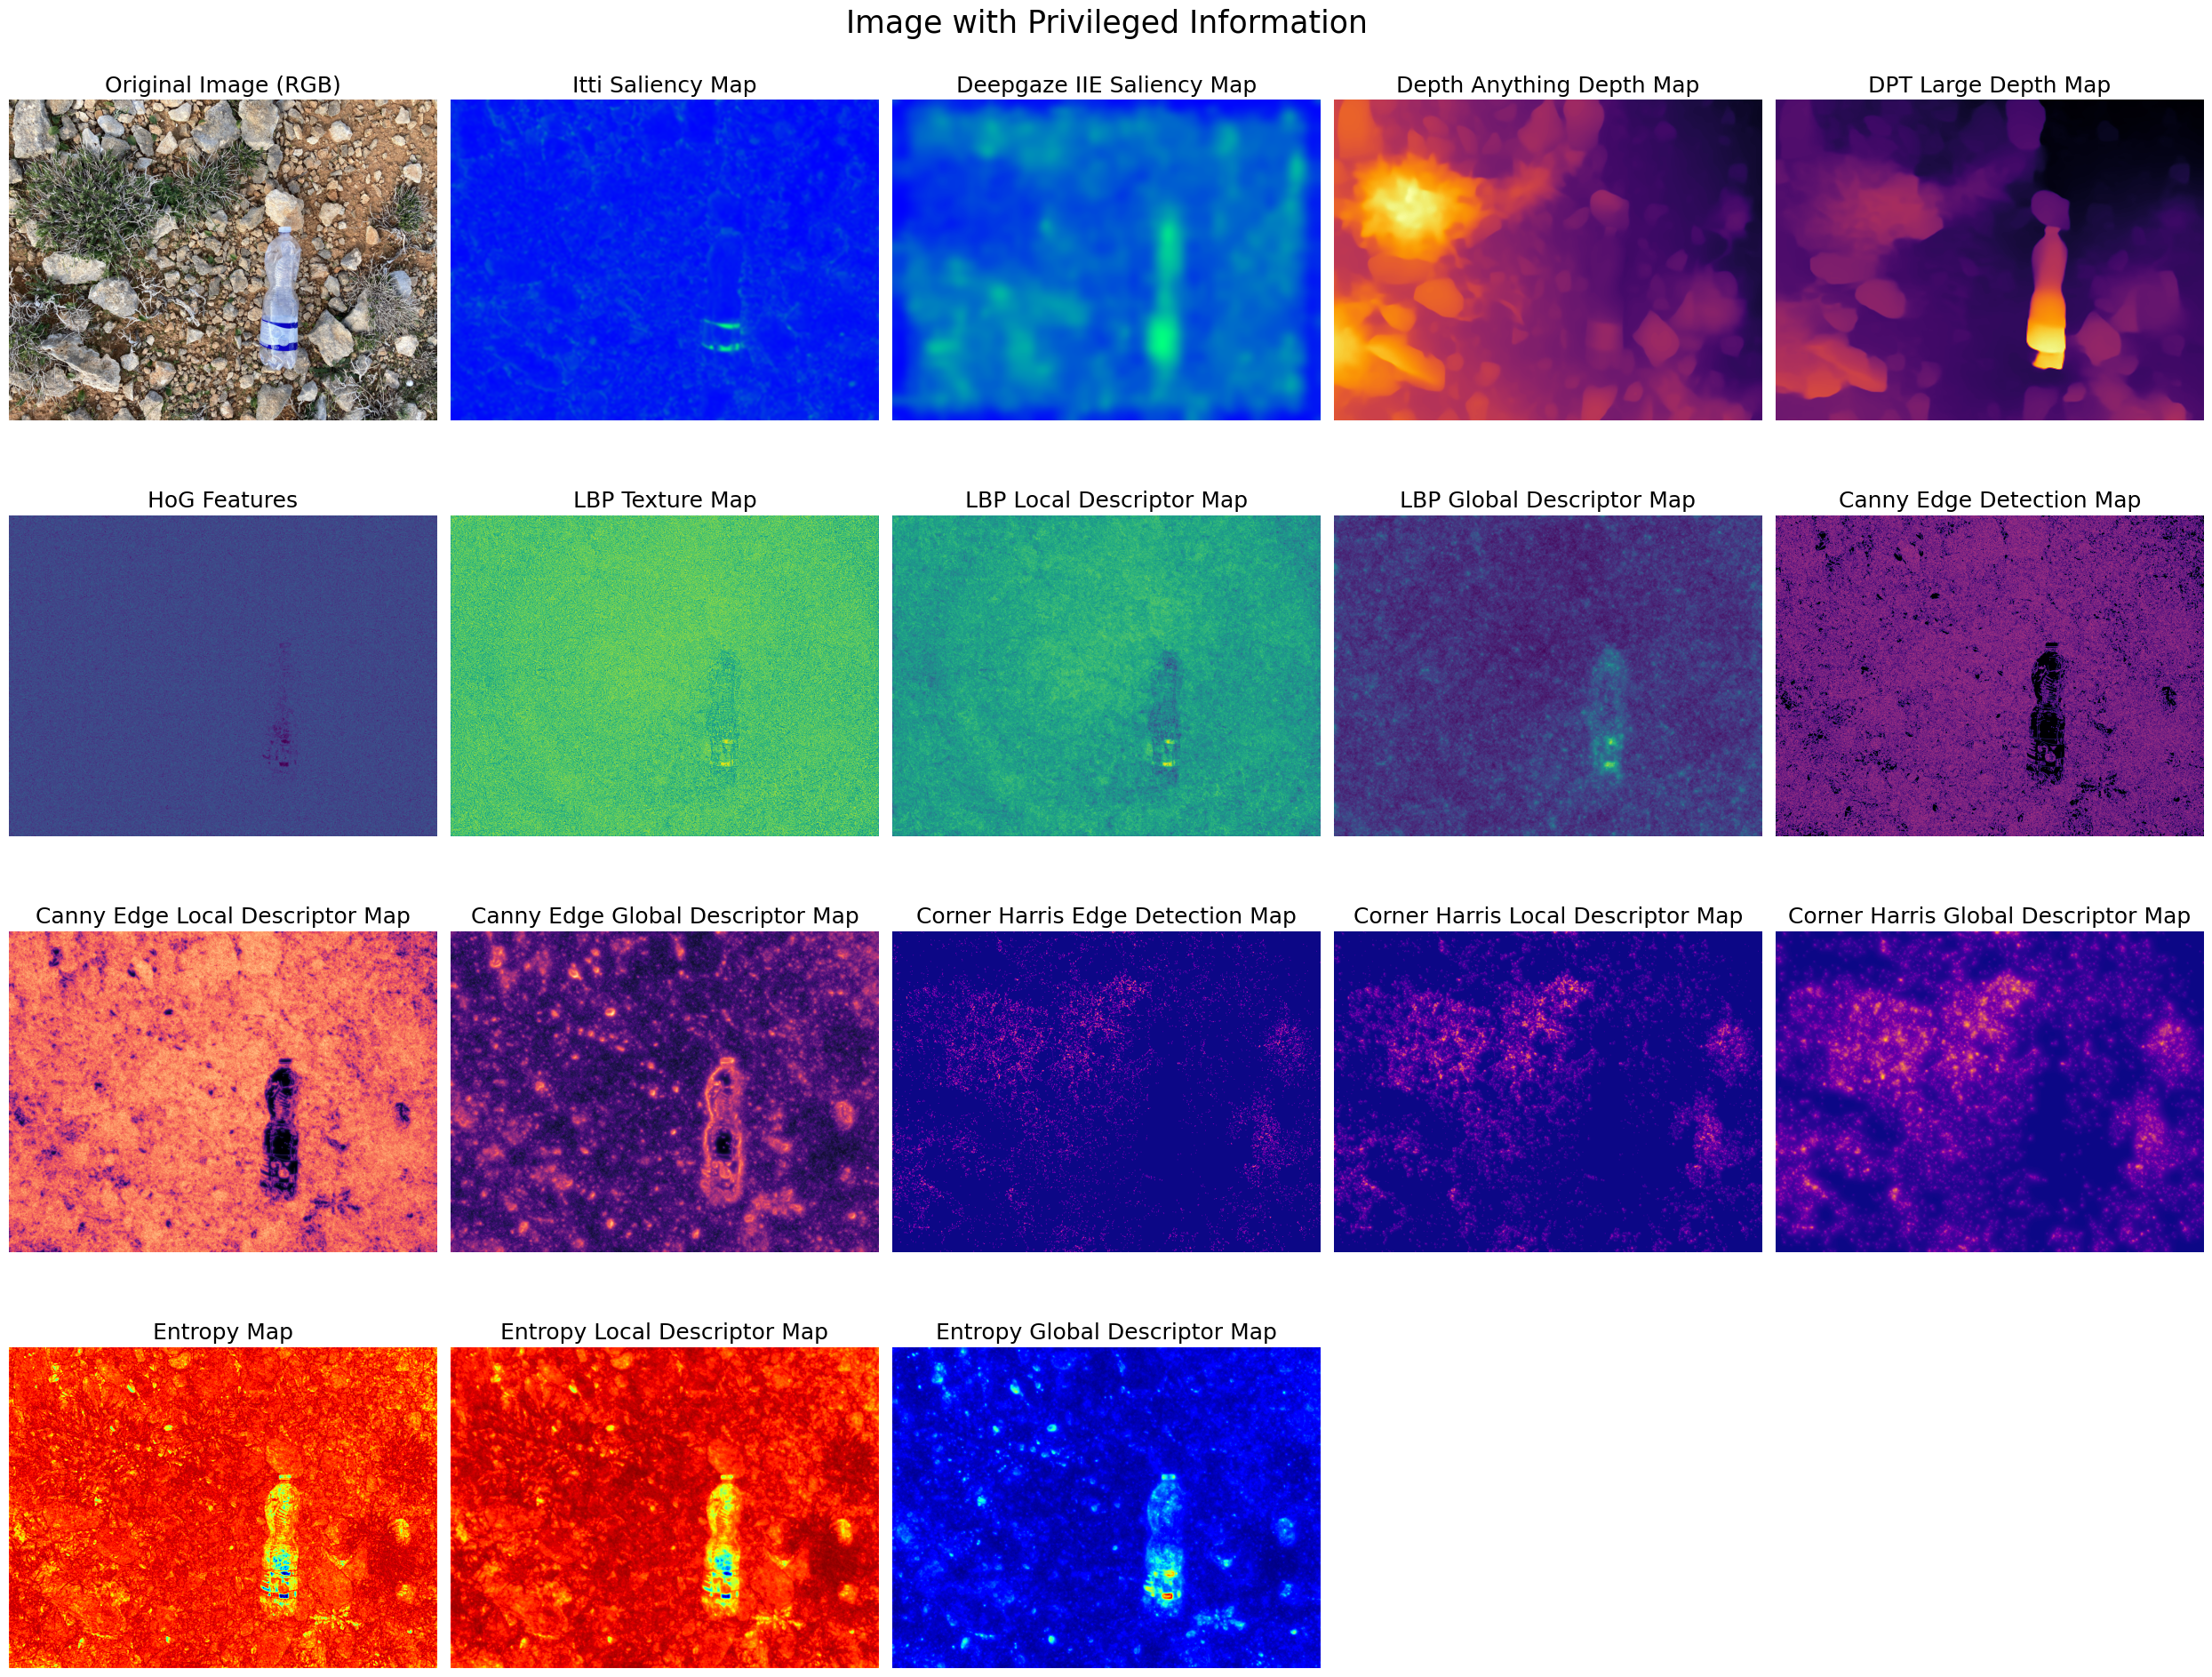

In [8]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

def choose_random_image_from_folder(folder_path):
    """
    Choose a random image from the specified folder.
    Args:
        folder_path (str): Path to the folder containing images.
    """
    # Get a list of all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    if not image_files:
        print(f"No image files found in {folder_path}.")
        return
    
    # Choose a random image from the list
    random_image = random.choice(image_files)
    
    # Full path to the random image
    random_image_path = os.path.join(folder_path, random_image)
    
    print(f"Randomly selected image: {random_image_path}")
    return random_image, random_image_path

def plot_image_with_privileged_info(image_paths_with_info):
    """Plot multiple images with different colormaps and add a suptitle."""
    columns = 5
    rows = (len(image_paths_with_info) + columns - 1) // columns  # Compute rows

    plt.figure(figsize=(25, rows * 5))
    plt.suptitle("Image with Privileged Information", fontsize=25)

    for idx, img_info in enumerate(image_paths_with_info):
        image_path = img_info['image_path']
        title = img_info['title']
        cmap = img_info['cmap']

        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        if image is None:
            print(f"Error loading image {image_path}.")
            continue

        if len(image.shape) == 3 and image.shape[2] == 3:  # Convert BGR to RGB if needed
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Normalise image via min-max scaling
        image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)

        plt.subplot(rows, columns, idx + 1)
        plt.imshow(image, cmap=cmap)
        plt.title(title, fontsize=18)
        plt.axis("off")

    plt.subplots_adjust(wspace=0.2, hspace=0.02)  # Reduce space between subplots
    plt.tight_layout()
    plt.show()

# Example usage: specify the path to your 'combined_images' and 'edge_images' folder
images_folder = '../datasets/01m-All-1/train/images'  # Replace with actual path
Itti_images_folder = '../datasets/01m-All-1/train/Saliency_itti'  # Replace with actual path
Deepgaze_images_folder = '../datasets/01m-All-1/train/Saliency_deepgaze'  # Replace with actual path
Depth_Anything_images_folder = '../datasets/01m-All-1/train/Depth_Depth_Anything'  # Replace with actual path
Dpt_Large_images_folder = '../datasets/01m-All-1/train/Depth_DPT_Large'  # Replace with actual path

HoG_images_folder = '../datasets/01m-All-1/train/HoG_Features'  # Replace with actual path

Lbp_images_folder = '../datasets/01m-All-1/train/LBP_Texture_Maps'  # Replace with actual path
Lbp_images_folder_local = '../datasets/01m-All-1/train/LBP_Texture_Maps_local'  # Replace with actual path
Lbp_images_folder_global = '../datasets/01m-All-1/train/LBP_Texture_Maps_global'  # Replace with actual path
Lbp_images_folder_window = '../datasets/01m-All-1/train/LBP_Texture_Maps_window'  # Replace with actual path

Canny_Edge_images_folder = '../datasets/01m-All-1/train/Canny_Edge_Maps'  # Replace with actual path
Canny_Edge_images_folder_local = '../datasets/01m-All-1/train/Canny_Edge_Maps_local'  # Replace with actual path
Canny_Edge_images_folder_global = '../datasets/01m-All-1/train/Canny_Edge_Maps_global'  # Replace with actual path
Canny_Edge_images_folder_window = '../datasets/01m-All-1/train/Canny_Edge_Maps_window'  # Replace with actual path

Harris_Corner_images_folder = '../datasets/01m-All-1/train/Harris_Corner_Maps'  # Replace with actual path
Harris_Corner_images_folder_local = '../datasets/01m-All-1/train/Harris_Corner_Maps_local'  # Replace with actual path
Harris_Corner_images_folder_global = '../datasets/01m-All-1/train/Harris_Corner_Maps_global'  # Replace with actual path
Harris_Corner_images_folder_window = '../datasets/01m-All-1/train/Harris_Corner_Maps_window'  # Replace with actual path

Entropy_images_folder = '../datasets/01m-All-1/train/Entropy_Maps'  # Replace with actual path
Entropy_images_folder_local = '../datasets/01m-All-1/train/Entropy_Maps_local'  # Replace with actual path
Entropy_images_folder_global = '../datasets/01m-All-1/train/Entropy_Maps_global'  # Replace with actual path
Entropy_images_folder_window = '../datasets/01m-All-1/train/Entropy_Maps_window'  # Replace with actual path

# Choose a random image from the combined images folder
random_image_name, random_image_path = choose_random_image_from_folder(images_folder)

# Construct the path for the corresponding image in each folder
itti_image_path = os.path.join(Itti_images_folder, random_image_name)
deepgaze_image_path = os.path.join(Deepgaze_images_folder, random_image_name)
depth_anything_image_path = os.path.join(Depth_Anything_images_folder, random_image_name)
dpt_large_image_path = os.path.join(Dpt_Large_images_folder, random_image_name)

hog_image_path = os.path.join(HoG_images_folder, random_image_name)

lbp_image_path = os.path.join(Lbp_images_folder, random_image_name)
lbp_image_path_local = os.path.join(Lbp_images_folder_local, random_image_name)
lbp_image_path_global = os.path.join(Lbp_images_folder_global, random_image_name)
lbp_image_path_window = os.path.join(Lbp_images_folder_window, random_image_name)

canny_edge_image_path = os.path.join(Canny_Edge_images_folder, random_image_name)
canny_edge_image_path_local = os.path.join(Canny_Edge_images_folder_local, random_image_name)
canny_edge_image_path_global = os.path.join(Canny_Edge_images_folder_global, random_image_name)
canny_edge_image_path_window = os.path.join(Canny_Edge_images_folder_window, random_image_name)

harris_corner_image_path = os.path.join(Harris_Corner_images_folder, random_image_name)
harris_corner_image_path_local = os.path.join(Harris_Corner_images_folder_local, random_image_name)
harris_corner_image_path_global = os.path.join(Harris_Corner_images_folder_global, random_image_name)
harris_corner_image_path_window = os.path.join(Harris_Corner_images_folder_window, random_image_name)

entropy_image_path = os.path.join(Entropy_images_folder, random_image_name)
entropy_image_path_local = os.path.join(Entropy_images_folder_local, random_image_name)
entropy_image_path_global = os.path.join(Entropy_images_folder_global, random_image_name)
entropy_image_path_window = os.path.join(Entropy_images_folder_window, random_image_name)

# Define a list of image paths with titles and colormap (cmap)
images_with_info = [
    {'image_path': random_image_path, 'title': 'Original Image (RGB)', 'cmap': 'gray'},
    {'image_path': itti_image_path, 'title': 'Itti Saliency Map', 'cmap': 'winter'},
    {'image_path': deepgaze_image_path, 'title': 'Deepgaze IIE Saliency Map', 'cmap': 'winter'},
    {'image_path': depth_anything_image_path, 'title': 'Depth Anything Depth Map', 'cmap': 'inferno'},
    {'image_path': dpt_large_image_path, 'title': 'DPT Large Depth Map', 'cmap': 'inferno'},

    {'image_path': hog_image_path, 'title': 'HoG Features', 'cmap': 'viridis'},

    {'image_path': lbp_image_path, 'title': 'LBP Texture Map', 'cmap': 'viridis'},
    {'image_path': lbp_image_path_local, 'title': 'LBP Local Descriptor Map', 'cmap': 'viridis'},
    {'image_path': lbp_image_path_global, 'title': 'LBP Global Descriptor Map', 'cmap': 'viridis'},
    # {'image_path': lbp_image_path_window, 'title': 'LBP Window Descriptor Map', 'cmap': 'viridis'},

    {'image_path': canny_edge_image_path, 'title': 'Canny Edge Detection Map', 'cmap': 'magma'},
    {'image_path': canny_edge_image_path_local, 'title': 'Canny Edge Local Descriptor Map', 'cmap': 'magma'},
    {'image_path': canny_edge_image_path_global, 'title': 'Canny Edge Global Descriptor Map', 'cmap': 'magma'},
    # {'image_path': canny_edge_image_path_window, 'title': 'Canny Edge Window Descriptor Map', 'cmap': 'magma'},

    {'image_path': harris_corner_image_path, 'title': 'Corner Harris Edge Detection Map', 'cmap': 'plasma'},
    {'image_path': harris_corner_image_path_local, 'title': 'Corner Harris Local Descriptor Map', 'cmap': 'plasma'},
    {'image_path': harris_corner_image_path_global, 'title': 'Corner Harris Global Descriptor Map', 'cmap': 'plasma'},
    # {'image_path': harris_corner_image_path_window, 'title': 'Corner Harris Window Descriptor Map', 'cmap': 'plasma'},

    {'image_path': entropy_image_path, 'title': 'Entropy Map', 'cmap': 'jet'},
    {'image_path': entropy_image_path_local, 'title': 'Entropy Local Descriptor Map', 'cmap': 'jet'},
    {'image_path': entropy_image_path_global, 'title': 'Entropy Global Descriptor Map', 'cmap': 'jet'},
    # {'image_path': entropy_image_path_window, 'title': 'Entropy Window Descriptor Map', 'cmap': 'jet'},
]

plot_image_with_privileged_info(images_with_info)